In [1]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR, EXTERNAL_DATA_DIR, MODELS_DIR
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

BREPNET_NPZ_DIR = INTERIM_DATA_DIR / "features" / "brepnet"

2025-09-18 21:31:41.107 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: D:\workspace\projects\freelance\Fusion3DNet


Project root added to path: d:\workspace\projects\freelance\Fusion3DNet


In [2]:
import numpy as np, pathlib as p
f = next(p.Path(INTERIM_DATA_DIR/'features/brepnet').glob('*.npz'))  # подставьте конкретный файл, на котором падает
with np.load(f) as z:
    print(f, z.files)
    for k in z.files:
        print(k, z[k].shape, z[k].dtype)

D:\workspace\projects\freelance\Fusion3DNet\data\interim\features\brepnet\42. Ejector-01.prt.npz ['face_features', 'face_point_grids', 'edge_features', 'coedge_point_grids', 'coedge_features', 'coedge_lcs', 'coedge_scale_factors', 'coedge_reverse_flags', 'next', 'mate', 'face', 'edge']
face_features (9, 7) float64
face_point_grids (9, 7, 10, 10) float64
edge_features (16, 10) float64
coedge_point_grids (31, 12, 10) float64
coedge_features (31, 1) float64
coedge_lcs (31, 4, 4) float64
coedge_scale_factors (31,) float64
coedge_reverse_flags (31,) float64
next (31,) uint32
mate (31,) uint32
face (31,) uint32
edge (31,) uint32


In [3]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from typing import List


# Импортируем классы из вашего файла
from src.modeling.vit_brep_ensemble.data_module.dataset import (
    CADItem,
    FusionCADDataset,
    build_brep_standardizer,
    save_stats,
    load_stats,
)

def get_clean_id(filename: str):
    name = Path(filename).stem
    if name.endswith('.prt'):
        name = name[:-4]
    return name

brep_features_dir = Path(INTERIM_DATA_DIR / "features/brepnet")
dino_features_dir = Path(INTERIM_DATA_DIR / "features/dino")
stats_path = Path(INTERIM_DATA_DIR / "features/pooled_brep.json")

# 2. Собираем объекты CADItem, находя общие файлы
brep_files = {p.stem: p for p in brep_features_dir.glob("*.npz")}
dino_files = {p.stem: p for p in dino_features_dir.glob("*.npz")}

# очистим id от лишних суффиксов
brep_files = {get_clean_id(k): v for k, v in brep_files.items()}

common_ids = sorted(brep_files.keys() & dino_files.keys())

print(f"Всего файлов BREP: {len(brep_files)}")
print(f"Всего файлов DINO: {len(dino_files)}")

all_items: List[CADItem] = []
for item_id in common_ids:
    item = CADItem(
        item_id=item_id,
        brep_npz_path=brep_files[item_id],
        dino_path=dino_files[item_id],
    )
    all_items.append(item)

print(f"Найдено {len(all_items)} общих элементов.")

# 3. Разделяем на обучающую и валидационную выборки (например, 80/20)
train_size = int(0.8 * len(all_items))
train_items = all_items[:train_size]
val_items = all_items[train_size:]

print("Вычисление статистики на основе тренировочных данных...")
standardizer = build_brep_standardizer(train_items)
print(f"Сохранение статистики в {stats_path}...")
save_stats(standardizer, stats_path)

if stats_path.exists():
    print(f"Загрузка статистики из {stats_path}")
    standardizer = load_stats(stats_path)
else:
    print("Создание и сохранение статистики...")
    standardizer = build_brep_standardizer(train_items)
    save_stats(standardizer, stats_path)

# 5. Создаем экземпляры датасета
train_dataset = FusionCADDataset(
    items=train_items,
    standardizer=standardizer
)
val_dataset = FusionCADDataset(
    items=val_items,
    standardizer=standardizer
)

print(f"Размер обучающего датасета: {len(train_dataset)}")
print(f"Размер валидационного датасета: {len(val_dataset)}")

def custom_collate_fn(batch):
    """
    Собирает батч, оставляя тензоры переменной длины (face_matrix) в виде списка.
    """
    views_list = [item['views'] for item in batch]
    face_matrix_list = [item['face_matrix'] for item in batch]
    item_id_list = [item['item_id'] for item in batch]

    
    views_batch = torch.stack(views_list, dim=0)

    return {
        'views': views_batch,
        'face_matrix': face_matrix_list,
        'item_id': item_id_list
    }

# 6. Используем DataLoader для итерации по данным
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

print(f'Shape dino features: {train_dataset[1]["views"].shape}')

batch = next(iter(train_loader))
print("Ключи в батче:", list(batch.keys()))
print("Размер 'views':", batch["views"].shape)
# 'face_matrix' теперь - это список, выведем размер первого элемента
print("'face_matrix' - это список из", len(batch["face_matrix"]), "тензоров.")
print("Размер первого 'face_matrix' в батче:", batch["face_matrix"][0].shape)
print("ID элементов:", batch["item_id"])

Всего файлов BREP: 129
Всего файлов DINO: 129
Найдено 128 общих элементов.
Вычисление статистики на основе тренировочных данных...


Вычисление статистики: 100%|██████████| 102/102 [00:00<00:00, 198.29it/s]


Сохранение статистики в D:\workspace\projects\freelance\Fusion3DNet\data\interim\features\pooled_brep.json...
Загрузка статистики из D:\workspace\projects\freelance\Fusion3DNet\data\interim\features\pooled_brep.json
Размер обучающего датасета: 102
Размер валидационного датасета: 26
Shape dino features: torch.Size([8, 384])
Ключи в батче: ['views', 'face_matrix', 'item_id']
Размер 'views': torch.Size([102, 8, 384])
'face_matrix' - это список из 102 тензоров.
Размер первого 'face_matrix' в батче: torch.Size([62, 7])
ID элементов: ['Камера газовая 3', 'Защелка 6', '43. Extractor', 'Зацеп трубки направляющий 1', 'Зацеп трубки направляющий', 'Защелка АК 1', '43. Extractor-09', '42. Silencer Fix-03', 'Затвор 3', '44. Extractor Pin-02', 'Затвор', 'Защелка 3', '44. Extractor Pin-07', '42. Silencer Fix-05', 'Камера газовая 8', 'Защелка АК 5', '44. Extractor Pin-04', 'Защелка 9', '43. Extractor-10', '42. Ejector-10', '43. Extractor-01', '44. Extractor Pin-01', 'Зацеп трубки направляющий 9', '43.

In [5]:
from src.modeling.vit_brep_ensemble.models.ensemble import ContrastiveFusionModel
from src.modeling.vit_brep_ensemble.data_module.data_loader import FusionDataModule 

data_module = FusionDataModule(
    brep_features_dir=brep_features_dir,
    dino_features_dir=dino_features_dir,
    stats_path=stats_path,
    batch_size=32,    
)
data_module.setup()
batch = next(iter(data_module.train_dataloader()))
model = ContrastiveFusionModel(embed_dim=256, learning_rate=1e-4)

with torch.no_grad():
    embeddings = model(batch)  
    dino_embed = embeddings["dino_embed"]
    brep_embed = embeddings["brep_embed"]
    print("dino:", dino_embed.shape, "brep:", brep_embed.shape)

Загрузка статистики из D:\workspace\projects\freelance\Fusion3DNet\data\interim\features\pooled_brep.json
dino: torch.Size([32, 256]) brep: torch.Size([32, 256])


In [6]:
from src.modeling.vit_brep_ensemble import train_enhanced

train_enhanced.main()

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:508: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:231: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name            | Type                | Params | Mode 
---------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 26. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasin

Training: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 38. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [7]:
from src.modeling.vit_brep_ensemble.data_module.enhanced_data_loader import EnhancedFusionDataModule

data_module = EnhancedFusionDataModule(
    brep_features_dir=brep_features_dir,
    dino_features_dir=dino_features_dir,
    stats_path=stats_path)

data_module.setup()
batch = next(iter(data_module.train_dataloader()))

print("Ключи в батче:", list(batch.keys()))
print("Размер 'views':", batch["views"].shape)
print("Размер первого 'face_matrix' в батче:", batch["face_matrix"][0].shape)
print("ID элементов:", batch["item_id"])

Ключи в батче: ['views', 'face_matrix', 'item_id']
Размер 'views': torch.Size([32, 8, 384])
Размер первого 'face_matrix' в батче: torch.Size([8, 7])
ID элементов: ['42. Ejector-09', '43. Extractor-06', '44. Extractor Pin-03', 'Защелка АК 2', '42. Ejector-06', '42. Silencer Fix-10', 'Затвор', '43. Extractor-01', 'Защелка 7', '42. Ejector-03', 'Затвор 5', 'Кожух 3', 'Защелка 2', 'Зацеп трубки направляющий', 'Защелка АК 4', 'Камера газовая 3', 'Камера газовая 7', '43. Extractor-10', '44. Extractor Pin-07', '42. Ejector-01', 'Защелка АК 8', '42. Ejector-07', '43. Extractor-08', 'Зацеп трубки направляющий 8', '44. Extractor Pin-09', 'Зацеп трубки направляющий 6', '44. Extractor Pin-04', '42. Ejector', 'Кожух 10', 'Защелка АК 5', '43. Extractor-02', 'Затвор 3']


🚀 Используем устройство: cpu
📦 Загружаем обученную модель...
📊 Подготавливаем данные...
🔄 Строим индекс эмбеддингов...
  Обрабатываем train split...


Extracting train embeddings:   0%|          | 0/2 [00:00<?, ?it/s]d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Extracting train embeddings: 100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


  Обрабатываем val split...


Extracting val embeddings: 100%|██████████| 1/1 [00:09<00:00,  9.38s/it]


✅ Индекс построен: 128 моделей, размерность 128
💾 Индекс сохранён: D:\workspace\projects\freelance\Fusion3DNet\models\search_index.npz

🔍 Примеры поиска:

📝 Запрос: 43. Extractor-07

🏆 Топ-10 похожих моделей:
   1. 43. Extractor-06 (схожесть: 0.9990)
   2. 43. Extractor-05 (схожесть: 0.9989)
   3. 43. Extractor-10 (схожесть: 0.9987)
   4. 43. Extractor-09 (схожесть: 0.9986)
   5. Защелка АК 3 (схожесть: 0.9985)
   6. 43. Extractor-04 (схожесть: 0.9983)
   7. Защелка АК 2 (схожесть: 0.9982)
   8. 43. Extractor (схожесть: 0.9979)
   9. Защелка АК 1 (схожесть: 0.9978)
  10. Защелка АК 5 (схожесть: 0.9978)


d:\workspace\projects\freelance\Fusion3DNet\src\modeling\vit_brep_ensemble\search_simulator.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='rank', y='similarity', palette='viridis')


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\workspace\\projects\\freelance\\Fusion3DNet\\notebooks\\results\\search_results_43. Extractor-07.png'

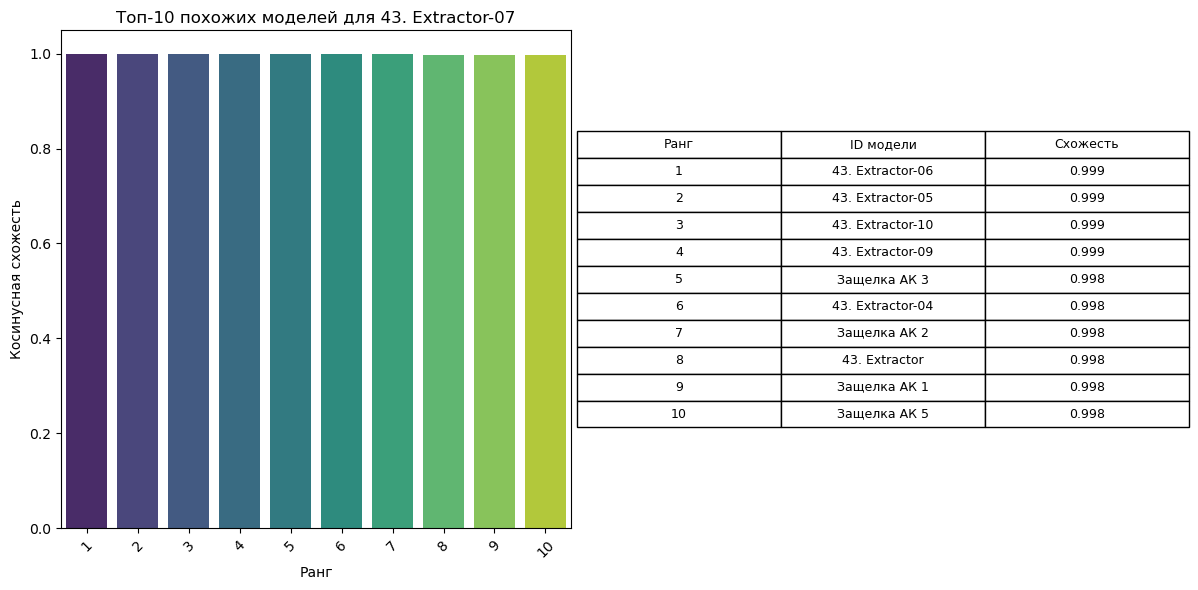

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from pathlib import Path
from src.modeling.vit_brep_ensemble.models.self_supervised_ensemble import SelfSupervisedFusionModel
from src.modeling.vit_brep_ensemble.data_module.enhanced_data_loader import EnhancedFusionDataModule
from src.modeling.vit_brep_ensemble.search_simulator import SearchSimulator





def interactive_search(simulator: SearchSimulator):
    """Интерактивный поиск"""
    
    print("\n🎮 Интерактивный поиск (введите 'quit' для выхода)")
    
    while True:
        query_id = input("\nВведите ID модели для поиска: ").strip()
        
        if query_id.lower() in ['quit', 'exit', 'q']:
            break
            
        if query_id not in simulator.embeddings_cache: # type: ignore
            print(f"❌ Модель '{query_id}' не найдена в индексе")
            
            # Показываем доступные ID (первые 10)
            available_ids = list(simulator.embeddings_cache.keys())[:10] # type: ignore
            print(f"Доступные ID (первые 10): {available_ids}")
            continue
        
        try:
            top_k = int(input("Количество результатов (по умолчанию 10): ") or "10")
        except ValueError:
            top_k = 10
        
        results = simulator.search_similar(query_id, top_k=top_k)
        
        print(f"\n🎯 Результаты поиска для '{query_id}':")
        for rank, (item_id, similarity) in enumerate(results, 1):
            print(f"  {rank:2d}. {item_id} (схожесть: {similarity:.4f})")


best_checkpoint_path = MODELS_DIR / "enhanced_fusion" / "fusion-epoch=51-val_loss=0.017.ckpt"
brep_features_dir = Path(INTERIM_DATA_DIR / "features/brepnet")
dino_features_dir = Path(INTERIM_DATA_DIR / "features/dino")
stats_path = Path(INTERIM_DATA_DIR / "features/pooled_brep.json")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Используем устройство: {device}")

# Загружаем модель
print("📦 Загружаем обученную модель...")
model = SelfSupervisedFusionModel.load_from_checkpoint(best_checkpoint_path)
model.eval()
model.to(device)

# Подготавливаем данные
print("📊 Подготавливаем данные...")
data_module = EnhancedFusionDataModule(
    brep_features_dir=brep_features_dir,
    dino_features_dir=dino_features_dir,
    stats_path=stats_path,
    batch_size=64,  # Увеличиваем для быстрого извлечения эмбеддингов
    num_workers=8
)
data_module.setup()

# Создаём симулятор
simulator = SearchSimulator(model, data_module, device)

# Строим индекс
simulator.build_index(use_train=True, use_val=True)

# Сохраняем индекс для будущего использования
index_path = Path(MODELS_DIR / "search_index.npz")
simulator.save_index(index_path)

# Примеры поиска
print("\n🔍 Примеры поиска:")

# Берём случайную модель для демонстрации
query_id = np.random.choice(simulator.item_ids)
print(f"\n📝 Запрос: {query_id}")

# Поиск топ-10
results = simulator.search_similar(query_id, top_k=10)

print(f"\n🏆 Топ-10 похожих моделей:")
for rank, (item_id, similarity) in enumerate(results, 1):
    print(f"  {rank:2d}. {item_id} (схожесть: {similarity:.4f})")

# Визуализация
simulator.visualize_search_results(
    query_id, 
    top_k=10, 
    save_path=Path(f"results/search_results_{query_id}.png")
)

# Оценка качества
print("\n📈 Оценка качества поиска...")
metrics = simulator.evaluate_retrieval(top_k=10)

print("\n📊 Метрики качества:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

# Интерактивный поиск
interactive_search(simulator)


